### Prepare Data

#### Connect & Import Data

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#read files from MoH's github
#daily updated aggregate deaths
linelist_deaths = 'https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/linelist/linelist_deaths.csv'

#daily updated vaccinations by age group, at district level
vax = 'https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/vaccination/vax_state.csv'

In [2]:
#load file into dataframe
df1 = pd.read_csv(linelist_deaths)
df2 = pd.read_csv(vax)

#### Explore Data

In [3]:
#organise data in df1
#1.Segment age group
age_group = pd.cut(df1["age"], bins = [-1,5,12,18,30,40,50,60,70,80,131], labels= ['0-4','5-11','12-17','18-29','30-39','40-49','50-59','60-69','70-79','80+'])
df1.insert(11, 'age_group', age_group)

#2.reorganise gender category
gender = df1['male'].replace([0,1],['Female','Male'], inplace=True)
df1.rename(columns={"male":"gender"},inplace=True)

#3.add a new column "VaxStatus"
#set default value as 'unvax'
df1['vaxStatus'] = 'unvax' 
#replace empty cell with "None" for 3 columns("date_dose1", "date_dose2", "date_dose3")
df1["date_dose1"].fillna("None", inplace = True) 
df1["date_dose2"].fillna("None", inplace = True)
df1["date_dose3"].fillna("None", inplace = True) 
# find all rows that fulfills conditions and set class to partialvax(1 dose), fullyvax(2 dose),boosted(3 dose)
df1['vaxStatus'].loc[(df1['date_dose1'] != "None") &
                    (df1['date_dose2'] == "None") &
                   (df1['date_dose3'] == "None")] = 'partialvax' 

df1['vaxStatus'].loc[(df1['date_dose1'] != "None") &
                    (df1['date_dose2'] != "None") &
                   (df1['date_dose3'] == "None")] = 'fullyvax' 

df1['vaxStatus'].loc[(df1['date_dose1'] != "None") &
                    (df1['date_dose2'] != "None") &
                   (df1['date_dose3'] != "None")] = 'boosted' 

#4.add a new column to quantify death case "death_case"
df1["death_case"] = 1

C:\Users\siehf\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [4]:
#create a new df - df3 -to aggregate the total death values by vax status
df3 = df1.pivot_table(index=["date"], columns=["vaxStatus"], values=["death_case"], aggfunc="sum").fillna(0).reset_index()
df3.columns = ["date","boosted","fullyvax","partialvax","unvax"]
df3 = df3[["date","boosted","fullyvax","partialvax","unvax"]].set_index("date")

#create a new df - df4 -to group daily_partial, daily_full, daily_booster 
group_by_state = df2.groupby(['date'])
df4 = pd.DataFrame(group_by_state["daily_partial","daily_full","daily_booster"].agg(np.sum)).reset_index()
df4.columns = ["date","daily_partial","daily_full","daily_booster"]
df4 = df4[["date","daily_partial","daily_full","daily_booster"]].set_index("date")

#merge df3 to df4
df4 = pd.merge(df4,df3, on=["date"], how="left").fillna(0).reset_index()
df4.columns = ["date","daily_partial","daily_full","daily_booster","boosted","fullyvax","partialvax","unvax"]
df4 = df4[["date","daily_partial","daily_full","daily_booster","boosted","fullyvax","partialvax","unvax"]].set_index("date")

#add new column - total_daily_death
df4["total_daily_death"] = df4["boosted"]+df4["fullyvax"]+df4["partialvax"]+df4["unvax"]
df4.tail()

<ipython-input-4-b92fabe1ca56>:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df4 = pd.DataFrame(group_by_state["daily_partial","daily_full","daily_booster"].agg(np.sum)).reset_index()


,daily_partial,daily_full,daily_booster,boosted,fullyvax,partialvax,unvax,total_daily_death
date,,,,,,,,
2022-04-17,11399,47325,3619,3.0,0.0,0.0,4.0,7.0
2022-04-18,9096,42031,6335,5.0,4.0,0.0,3.0,12.0
2022-04-19,7738,36392,4835,1.0,2.0,0.0,1.0,4.0
2022-04-20,11444,45226,5568,0.0,0.0,0.0,0.0,0.0
2022-04-21,13412,39883,6165,0.0,0.0,0.0,0.0,0.0


### Visualise Data

#### (i) Correlation between Death Case and Vaccine Coverage:

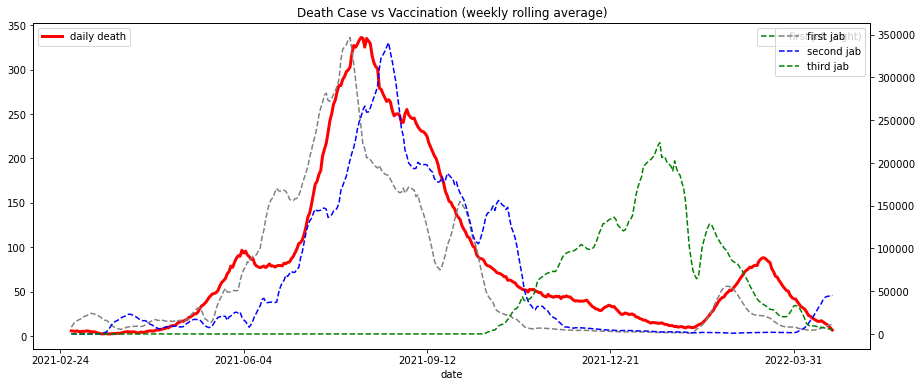

In [5]:
#plot the rolling average of the 'total_daily_death' vs 'vaccination' readings. Use a window size of 7 (7 days in a week)
fig,ax = plt.subplots(figsize=(15,6))
df4.rolling(7).mean().plot(y = 'total_daily_death',label="daily death",linewidth=3, color="red", ax = ax)
ax.legend(loc="upper left")

# Plot the second axis
ax2 = ax.twinx()
df4.rolling(7).mean().plot(y = 'daily_partial',label="first jab",color="grey", linestyle='dashed', ax = ax2, secondary_y = True)
df4.rolling(7).mean().plot(y = 'daily_full', label="second jab", color="blue", linestyle='dashed', ax = ax2, secondary_y = True)
df4.rolling(7).mean().plot(y = 'daily_booster', label="third jab", color="green", linestyle='dashed', ax = ax2, secondary_y = True)
plt.legend(loc="upper right")

plt.title("Death Case vs Vaccination (weekly rolling average)")
plt.show();

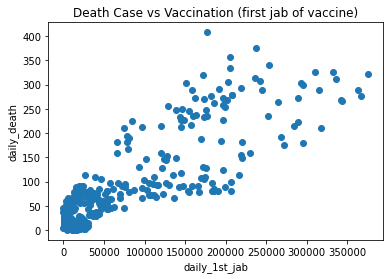

In [6]:
#Correlation between death case vs vaccination (1st jab)
plt.scatter(x=df4["daily_partial"], y=df4["total_daily_death"])
plt.xlabel("daily_1st_jab")
plt.ylabel("daily_death")
plt.title("Death Case vs Vaccination (first jab of vaccine)");

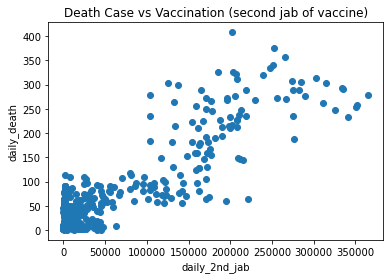

In [7]:
#Correlation between death case vs vaccination (2nd jab)
plt.scatter(x=df4["daily_full"], y=df4["total_daily_death"])
plt.xlabel("daily_2nd_jab")
plt.ylabel("daily_death")
plt.title("Death Case vs Vaccination (second jab of vaccine)");

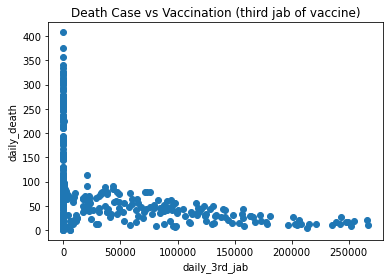

In [8]:
#Correlation between death case vs vaccination (3rd jab)
plt.scatter(x=df4["daily_booster"], y=df4["total_daily_death"])
plt.xlabel("daily_3rd_jab")
plt.ylabel("daily_death")
plt.title("Death Case vs Vaccination (third jab of vaccine)");